In [2]:
# The imports 
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [3]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from keras import layers
from keras.models import Model, load_model
from keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
!unzip /kaggle/input/diabetic-retinopathy-detection/trainLabels.csv.zip
! unzip /kaggle/input/diabetic-retinopathy-detection/sampleSubmission.csv.zip

Archive:  /kaggle/input/diabetic-retinopathy-detection/trainLabels.csv.zip
  inflating: trainLabels.csv         
Archive:  /kaggle/input/diabetic-retinopathy-detection/sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


In [5]:
train_lbl = pd.read_csv('/kaggle/working/trainLabels.csv')
train_img = glob('/kaggle/input/diabetic-retinopathy-train-unzipped/train/*.jpeg')
train_names = [os.path.basename(path).replace('.jpeg', '') for path in train_img]
train_df = pd.DataFrame({'image': train_names, 'image_path': train_img})
train_df = pd.merge(train_lbl, train_df, on='image')
train_df.head()




,image,level,image_path
0,10_left,0,/kaggle/input/diabetic-retinopathy-train-unzip...
1,10_right,0,/kaggle/input/diabetic-retinopathy-train-unzip...
2,13_left,0,/kaggle/input/diabetic-retinopathy-train-unzip...
3,13_right,0,/kaggle/input/diabetic-retinopathy-train-unzip...
4,15_left,1,/kaggle/input/diabetic-retinopathy-train-unzip...


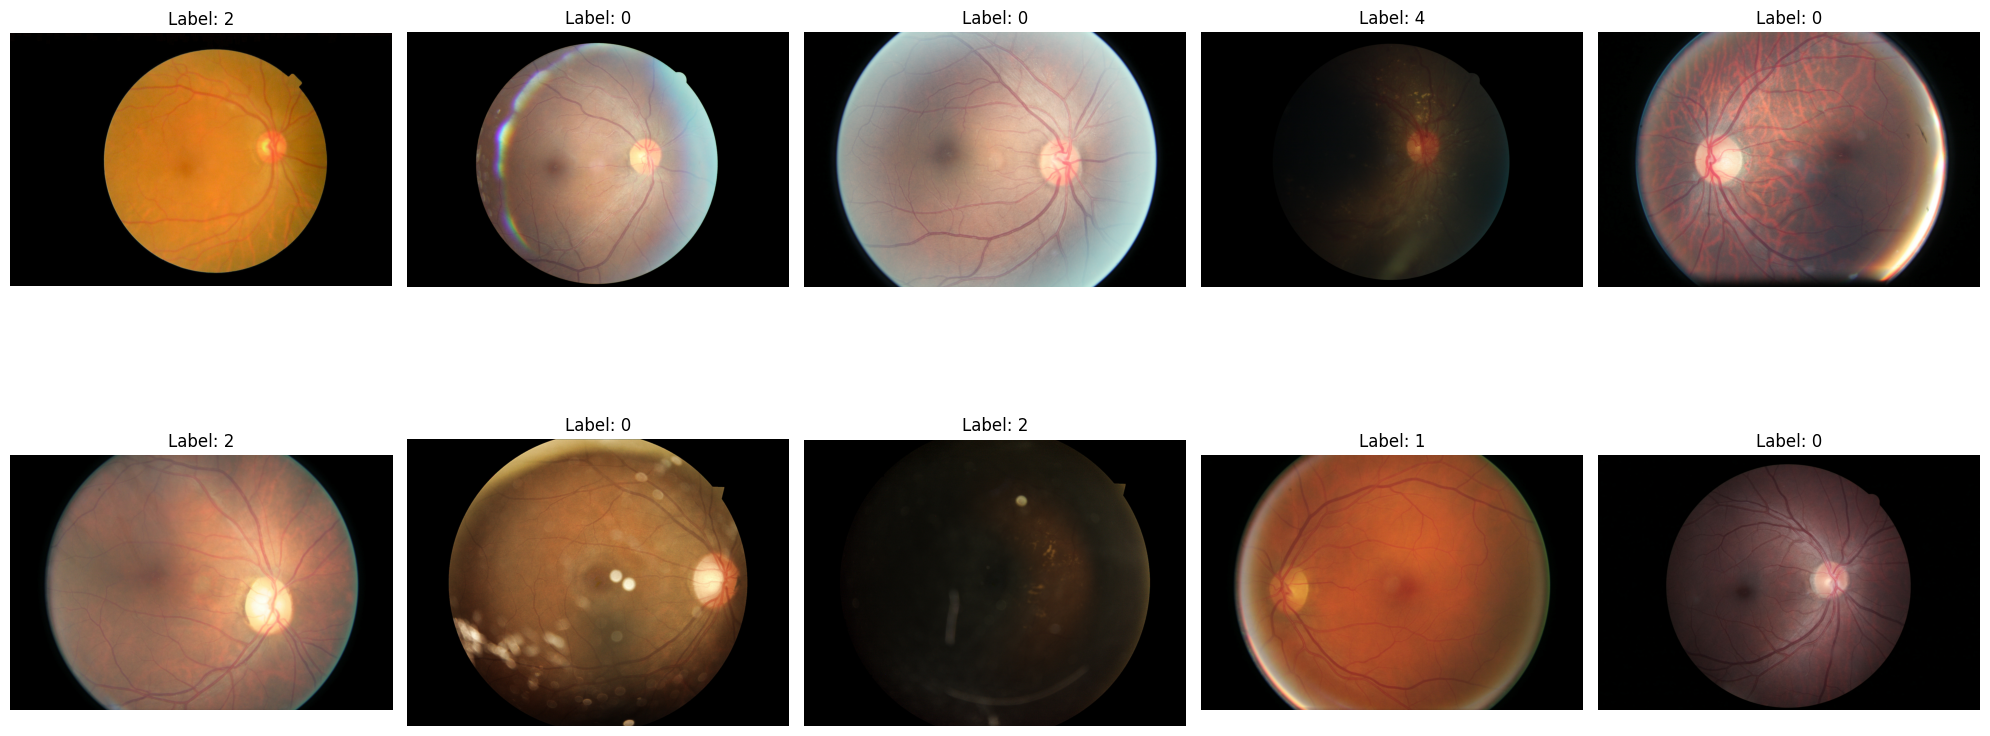

In [6]:
# display sample of the data 
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
ax = axes.flatten()

for i in range(10):
    row = train_df.sample(10).iloc[i]
    img = Image.open(row['image_path'])
    ax[i].imshow(img)
    ax[i].set_title(f"Label: {row['level']}")
    ax[i].axis('off')

plt.tight_layout()
plt.show()

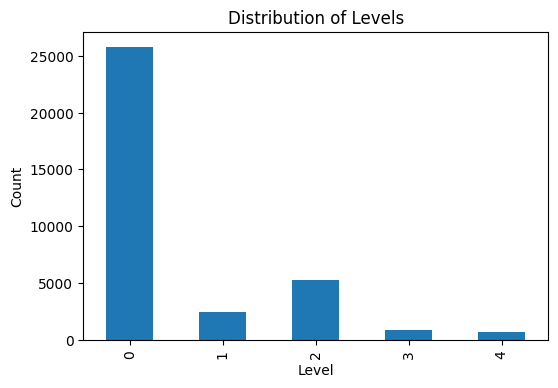

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
train_df['eye'] = train_df['image'].apply(lambda x: x.split('_')[-1])

# plot histogram 
plt.figure(figsize=(6, 4))
train_df['level'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Levels')
plt.xlabel('Level')
plt.ylabel('Count')
plt.show()

# the distribution of levels needs to be more balanced 

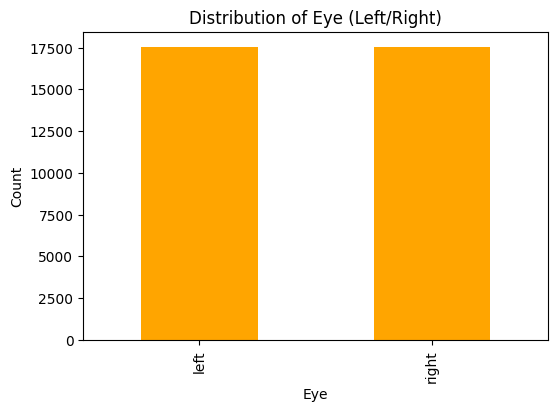

In [8]:
# histogram for right and left eye 
plt.figure(figsize=(6, 4))
train_df['eye'].value_counts().plot(kind='bar', color='orange')
plt.title('Distribution of Eye (Left/Right)')
plt.xlabel('Eye')
plt.ylabel('Count')
plt.show()

In [9]:
# split data into validation and test
from sklearn.model_selection import train_test_split

train_df['PatientId'] = train_df['image'].map(lambda x: x.split('_')[0])

rr_df = train_df[['PatientId', 'level']].drop_duplicates()

train_df['PatientId'] = train_df['image'].map(lambda x: x.split('_')[0])



train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])


raw_train_df = train_df[train_df['PatientId'].isin(train_ids)]
valid_df = train_df[train_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])



train 27176 validation 9632


In [10]:
balanced_train_df = raw_train_df.groupby(['level', 'eye']).apply(
    lambda x: x.sample(1000, replace=True, random_state=42)  # adjust sample size as needed
).reset_index(drop=True)

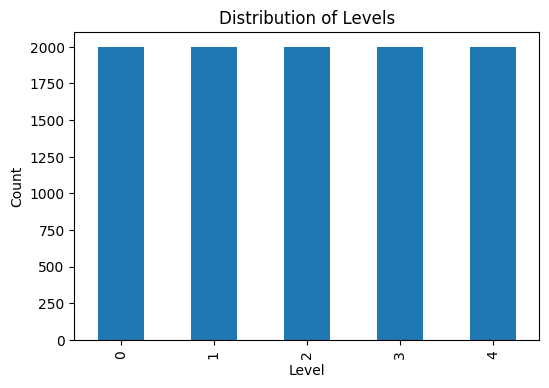

In [11]:
# drop new training set histogram 

plt.figure(figsize=(6, 4))
balanced_train_df['level'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Levels')
plt.xlabel('Level')
plt.ylabel('Count')
plt.show()

In [12]:
train_df.head()

,image,level,image_path,eye,PatientId
0,10_left,0,/kaggle/input/diabetic-retinopathy-train-unzip...,left,10
1,10_right,0,/kaggle/input/diabetic-retinopathy-train-unzip...,right,10
2,13_left,0,/kaggle/input/diabetic-retinopathy-train-unzip...,left,13
3,13_right,0,/kaggle/input/diabetic-retinopathy-train-unzip...,right,13
4,15_left,1,/kaggle/input/diabetic-retinopathy-train-unzip...,left,15


In [13]:
inputs = layers.Input(shape=(224, 224, 3))
model = EfficientNetB0(include_top=False, input_tensor=inputs, weights='imagenet')
model.trainable = False
x = layers. GlobalAveragePooling2D()(model.output)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(5, activation='softmax')(x)
model = Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model.summary()





Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,061,096 (15.49 MB)

 Trainable params: 8,965 (35.02 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [15]:
train_df['level'] = train_df['level'].astype(str)
valid_df['level'] = valid_df['level'].astype(str)

datagen = ImageDataGenerator(rescale=1./255)  # normalization of the images 
train_gen = datagen.flow_from_dataframe(      #  training generator
    train_df,
    x_col='image_path',
    y_col='level',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',  # because you're using softmax and categorical_crossentropy
    batch_size=32,
    shuffle=True
)

val_gen = datagen.flow_from_dataframe(      #validation set:
    valid_df,
    x_col='image_path',
    y_col='level',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 35126 validated image filenames belonging to 5 classes.
Found 9632 validated image filenames belonging to 5 classes.


In [16]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-3)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Since you're using softmax and one-hot labels
    metrics=['accuracy']
)

In [17]:
# callbacks to improve and control your training process
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    save_best_only=True,
    monitor='val_loss'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

In [18]:
model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    callbacks=[model_checkpoint, early_stop, reduce_lr]
)


Epoch 1/10
1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7086 - loss: 0.9703

KeyboardInterrupt: 

In [21]:
# Plotting training results (accuracy/loss curves)

import matplotlib.pyplot as plt

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=1,
    callbacks=[model_checkpoint, early_stop, reduce_lr]
)

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1098/1098 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7285 - loss: 0.8996Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-f5f6e39f2661>", line 5, in <cell line: 5>
    history = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 345, in fit
    val_logs = self.evaluate(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 433, in evaluate
    logs = self.test_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/pyt

TypeError: object of type 'NoneType' has no len()